#Prever a quantidade de passageiros
(Forecast the number of passengers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import Series
from matplotlib.pylab import rcParams
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime

In [2]:
rcParams['figure.figsize'] = 15, 6

In [3]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

In [4]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


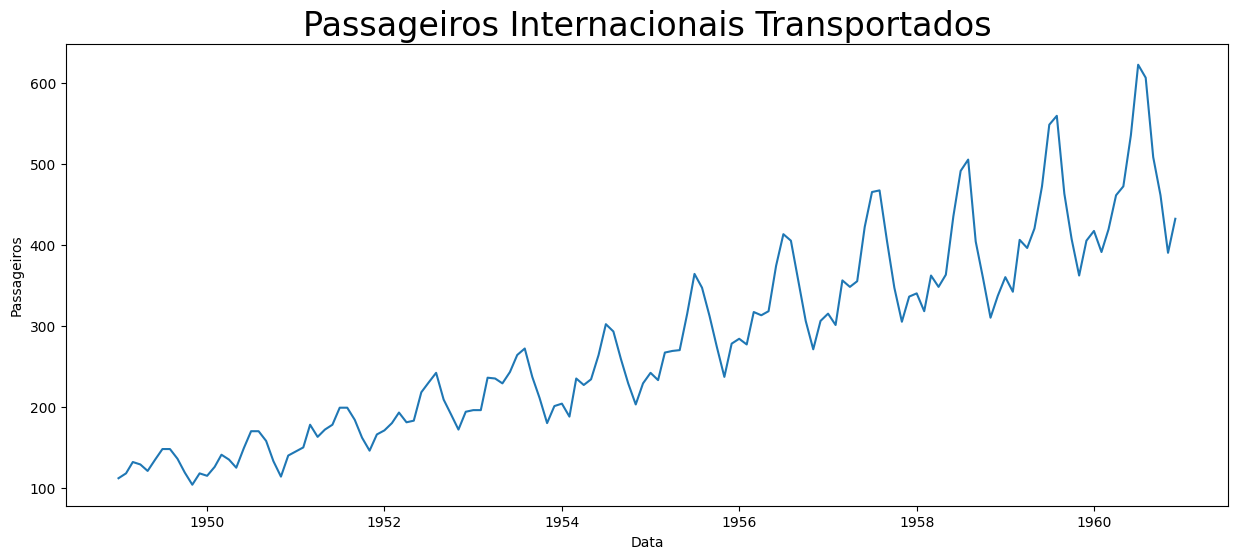

In [5]:
plt.plot(data)
plt.title('Passageiros Internacionais Transportados', fontsize=24)
plt.ylabel('Passageiros')
plt.xlabel('Data')
plt.show()

#Decomposição da série
(series decomposition)

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative')

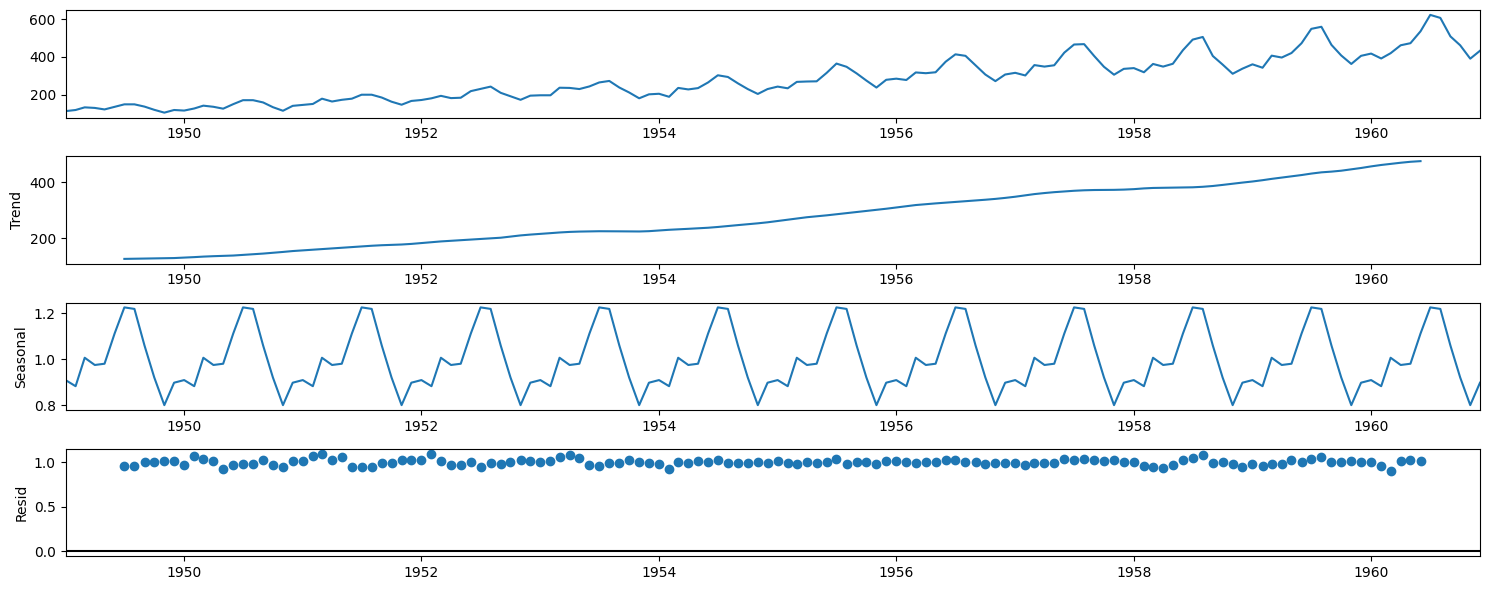

In [9]:
result.plot()
plt.show()

#Teste de Estacionariedade
(stationarity test)

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
X = data['#Passengers']
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: 0.815369
Valor de P: 0.991880
Valores Críticos:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#Suavização Exponencial Simples
(
Simple Exponential Smoothing)

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [28]:
data.index.freq = 'MS'
fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False) #alpha = 0.2: 20% de peso para as observações mais recentes, optimazed: acha um valor otimizado para o smoothing_level
fcast1 = fit1.forecast(12) #prever 12 intervalos para frente

In [29]:
fcast1

1961-01-01    469.630092
1961-02-01    469.630092
1961-03-01    469.630092
1961-04-01    469.630092
1961-05-01    469.630092
1961-06-01    469.630092
1961-07-01    469.630092
1961-08-01    469.630092
1961-09-01    469.630092
1961-10-01    469.630092
1961-11-01    469.630092
1961-12-01    469.630092
Freq: MS, dtype: float64

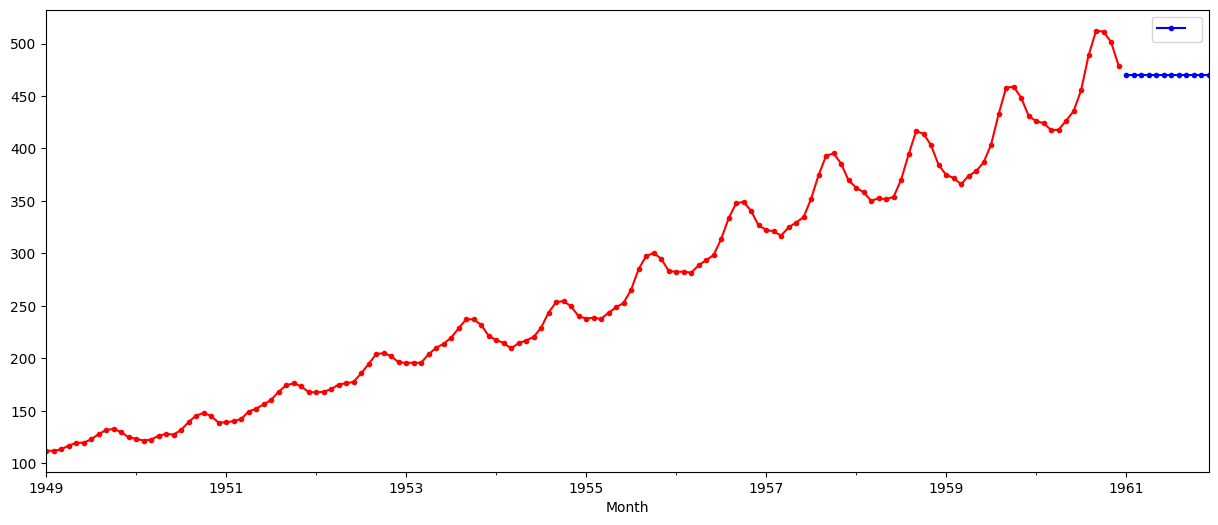

In [30]:
fcast1.plot(marker='.', color='blue', legend=True)
fit1.fittedvalues.plot(marker='.',  color='red')
plt.show()

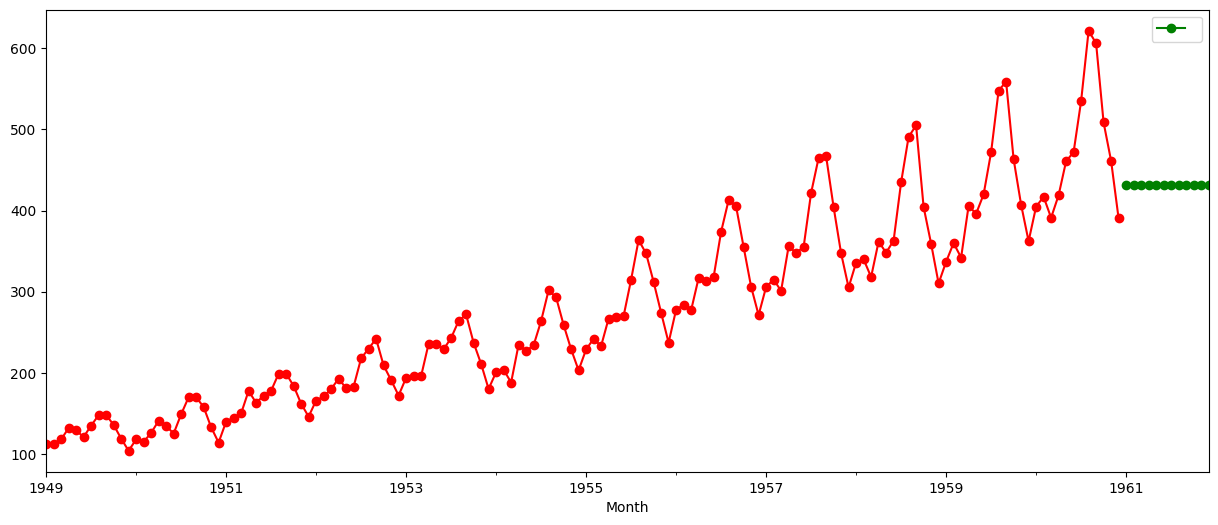

In [31]:
data.index.freq = 'MS'
fit3 = SimpleExpSmoothing(data).fit(optimized=True)
fcast3 = fit3.forecast(12)
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='red')
plt.show()

# Suavização Exponencial Simples e Amortecida
(
Simple and Damped Exponential Smoothing)

In [32]:
data.index.freq = 'MS'
# smoothing_trend (beta) 80% de influência na tendência mais atual
fit1 = Holt(data).fit(smoothing_level=0.2, smoothing_trend=0.8, optimized=False)
fcast1 = fit1.forecast(12)

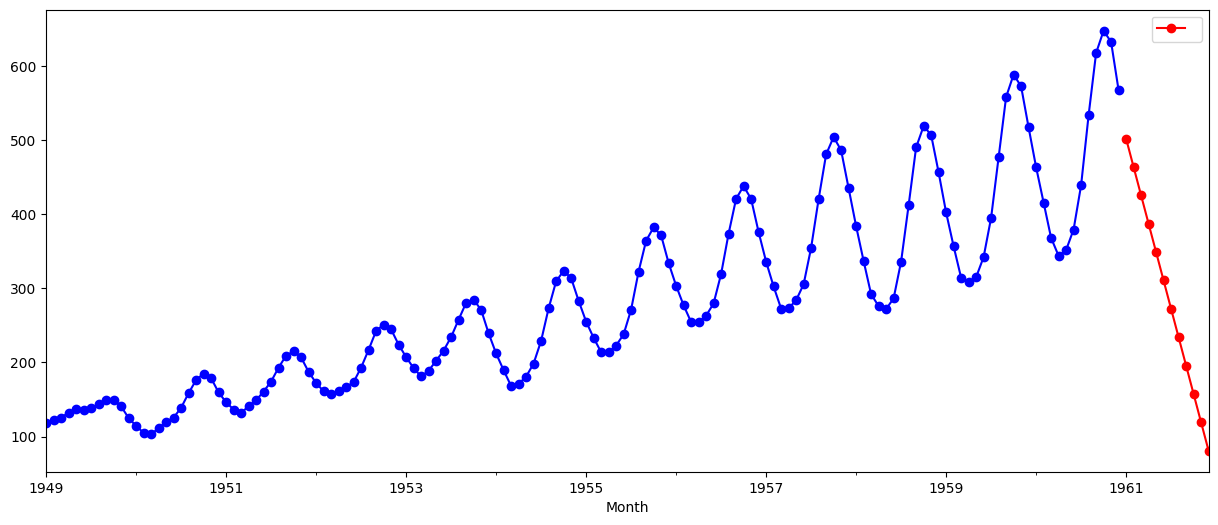

In [33]:
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='red', marker="o", legend=True)
plt.show()

In [34]:
data.index.freq = 'MS'
# suavização da tendência phi
fit3 = Holt(data, damped_trend=True).fit(smoothing_level=0.8, smoothing_trend=0.2)
fcast3 = fit3.forecast(12)

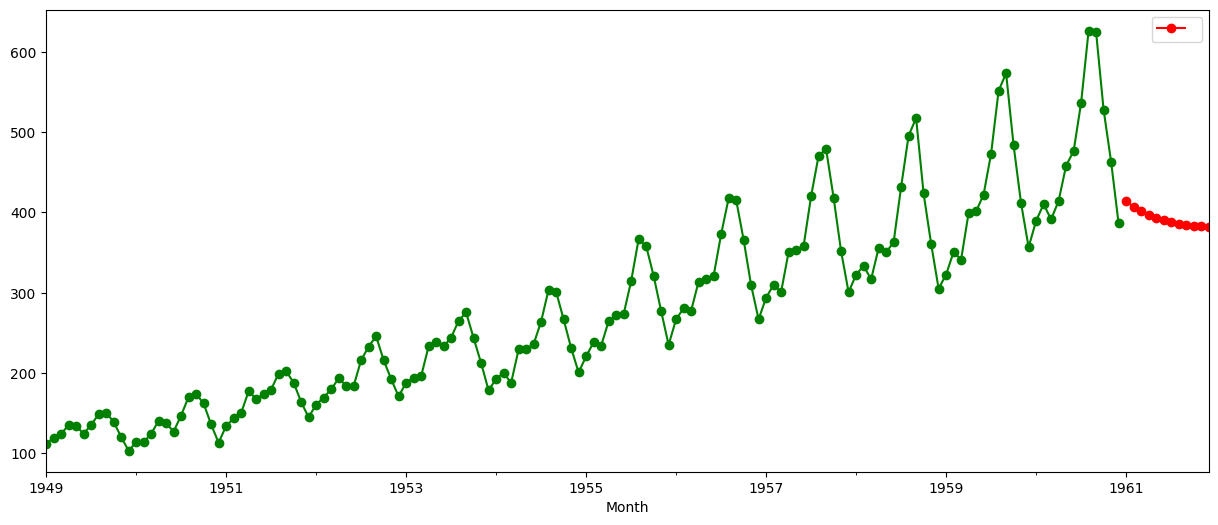

In [35]:
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='red', marker="o", legend=True)
plt.show()

# Holt Winters
Capaz de detectar os efeitos sazonais e tendencias

In [38]:
data.index.freq = 'MS'
fit1 = ExponentialSmoothing(data, seasonal_periods=12, trend='multiplicative', seasonal='multiplicative', use_boxcox=True).fit()

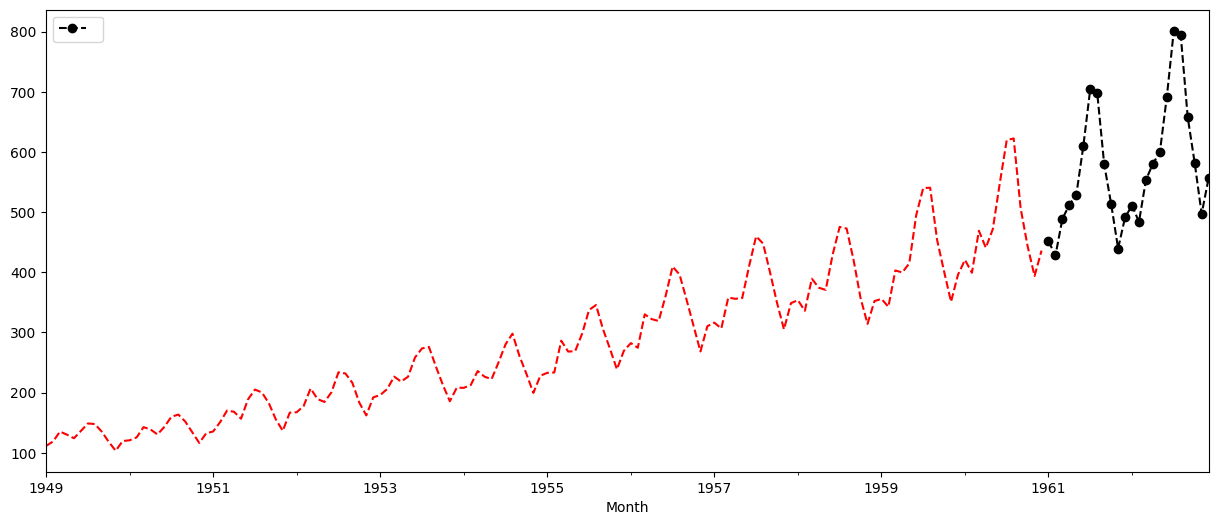

In [41]:
fit1.fittedvalues.plot(style='--', color='red')
fit1.forecast(24).plot(style='--', marker='o', color='black', legend=True)
plt.show()

#ARIMA

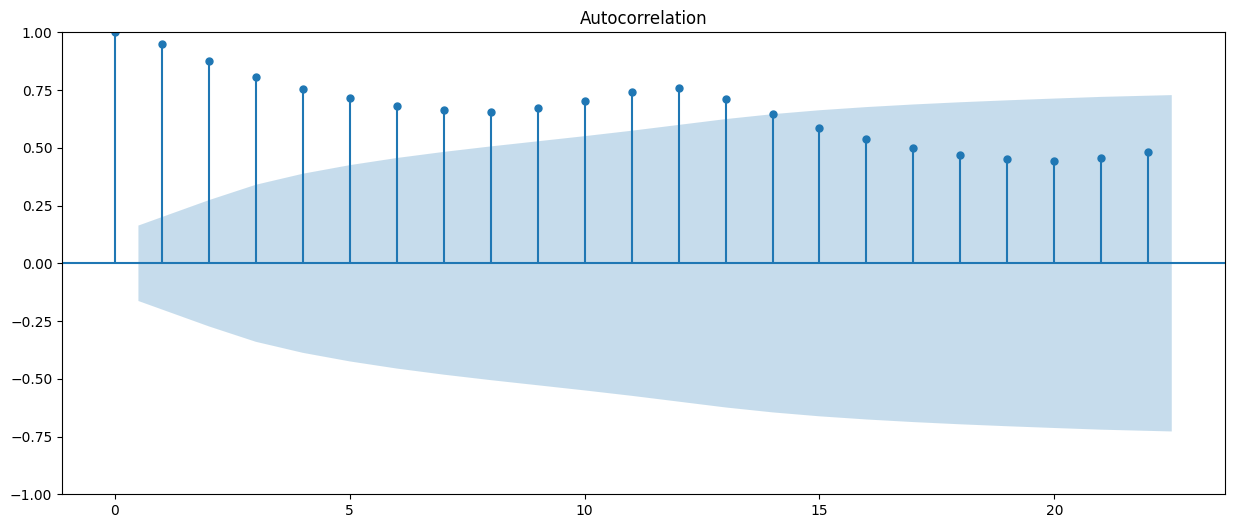

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plt.show()

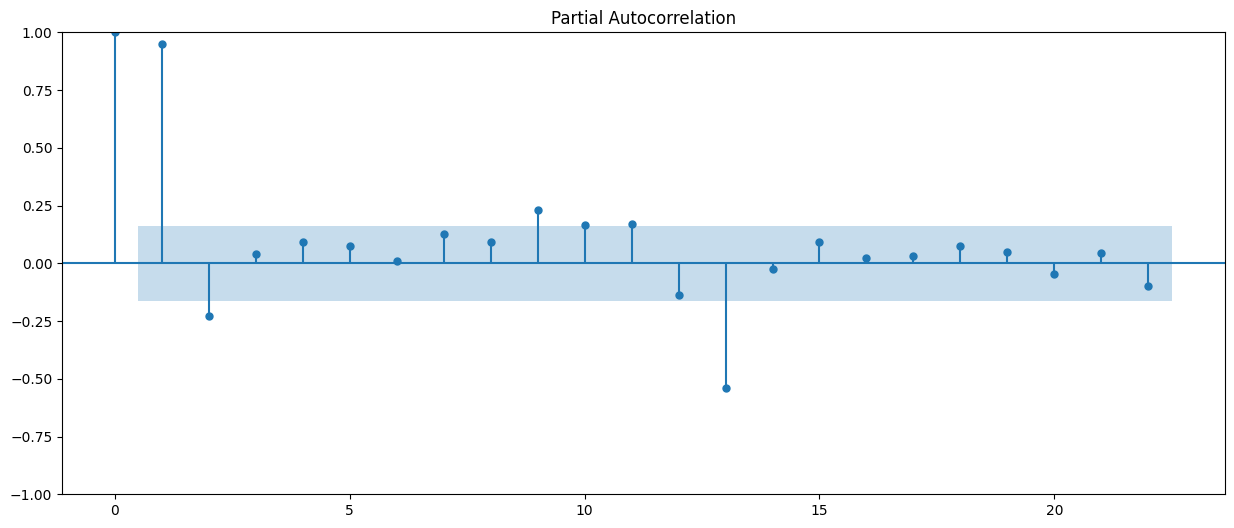

In [43]:
plot_pacf(data, method='ywm')
plt.show()

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
data.index.freq = 'MS'
model = ARIMA(data, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Sun, 30 Jul 2023   AIC                           1378.338
Time:                        19:17:50   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

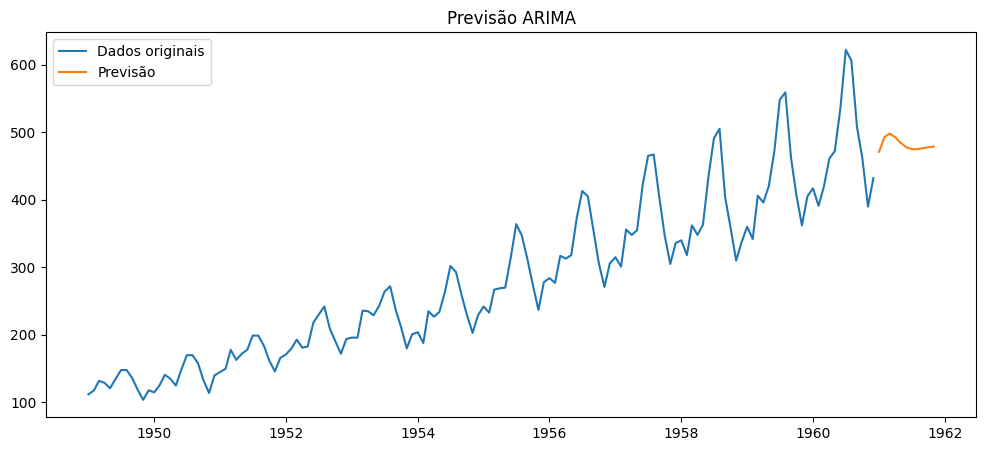

In [46]:
n_periods = 12
forecast = model_fit.forecast(steps=n_periods) #prevendo mais 12 meses
idx = pd.date_range(data.index[-1], periods=n_periods, freq='MS') #definindo datas das previsões
forecast_series = pd.Series(forecast, index=idx)
plt.figure(figsize=(12, 5))
plt.plot(data, label='Dados originais')
plt.plot(forecast_series, label='Previsão')
plt.title('Previsão ARIMA')
plt.legend()
plt.show()

#SARIMAX

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data, order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sun, 30 Jul 2023   AIC                           1019.178
Time:                                     19:19:02   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

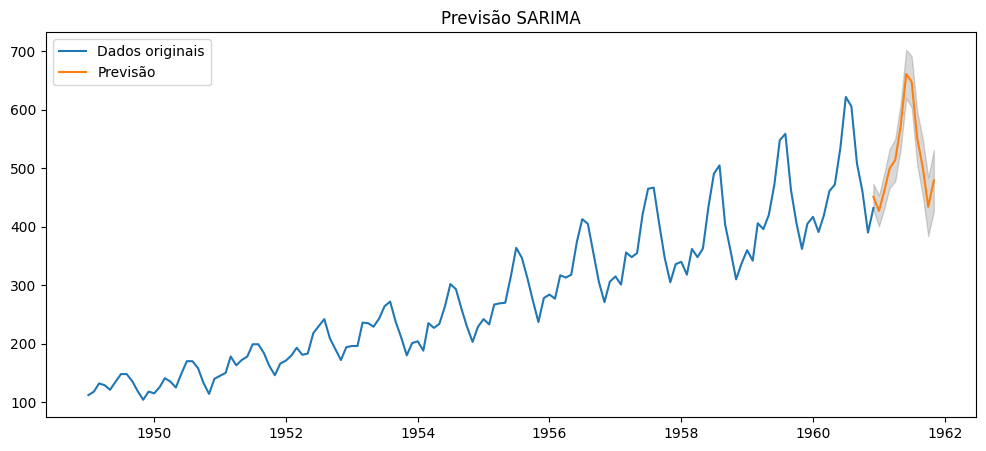

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
n_periods = 12
forecast_results = model_fit.get_forecast(steps=n_periods)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int() #intervalo de confiança, mais robusto
idx = pd.date_range(data.index[-1], periods=n_periods, freq='MS')
plt.figure(figsize=(12, 5))
plt.plot(data, label='Dados originais')
plt.plot(idx, forecast, label='Previsão')
plt.fill_between(idx, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)
plt.title('Previsão SARIMA')
plt.legend()
plt.show()

#AUTO ARIMA
Testa diferentes valores de p,d,q e encontra os melhores com base no AIC


In [50]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00


In [51]:
from pmdarima.arima import auto_arima

In [52]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=1.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=1.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=1.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.97 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=1.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.82 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=1.06 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=2.02 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=1.56 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.87 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=6.61 sec
 ARIMA(0,1,1)(1,1,1)[12]    

In [53]:
print(stepwise_model.aic())

1019.1780567487713


In [54]:
train = data.loc['1948-01-01':'1959-12-01']
test = data.loc['1960-01-01':]

In [55]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [56]:
future_forecast = stepwise_model.predict(n_periods=12)

In [57]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["#Passengers"])

In [58]:
future_forecast

,#Passengers
Month,
1960-01-01,421.153373
1960-02-01,401.605753
1960-03-01,462.083577
1960-04-01,450.826710
1960-05-01,475.124360
1960-06-01,529.774275
1960-07-01,605.741141
1960-08-01,618.774117
1960-09-01,516.769043


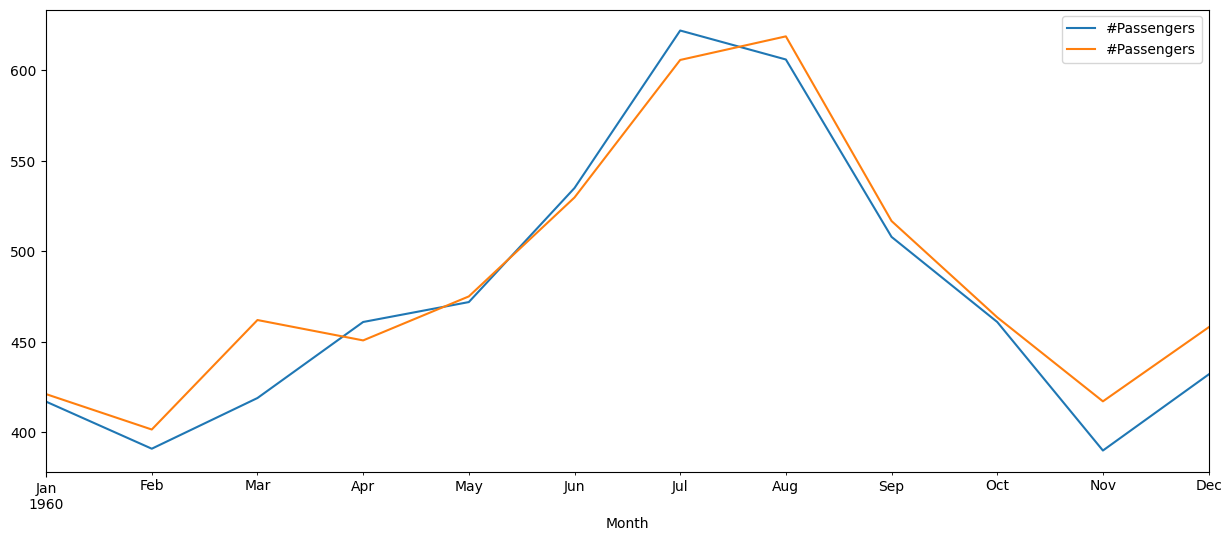

In [59]:
pd.concat([test,future_forecast],axis=1).plot()
plt.show()

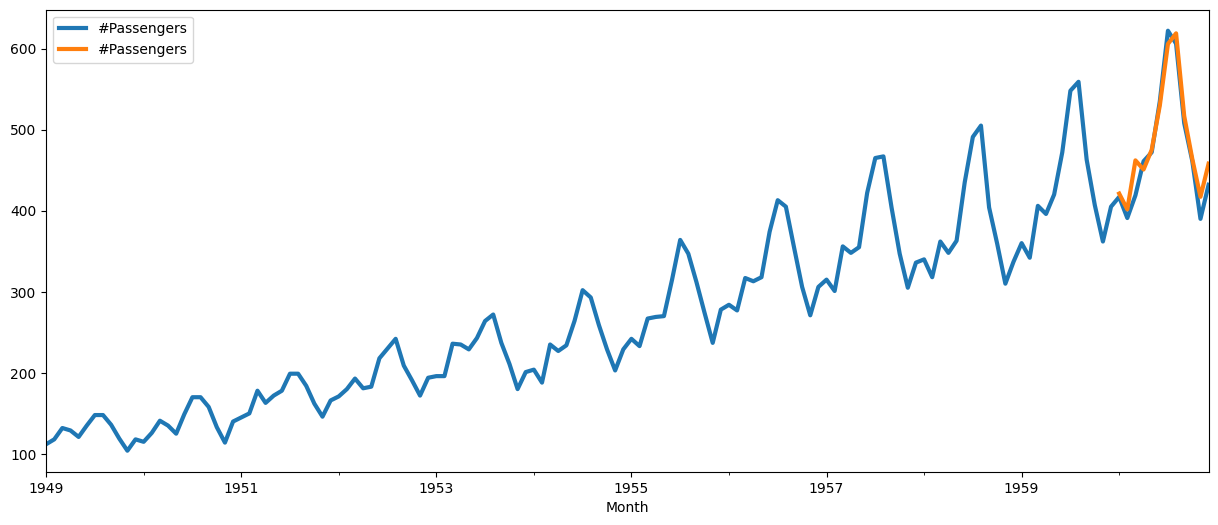

In [60]:
pd.concat([data,future_forecast],axis=1).plot(linewidth=3)
plt.show()

# Perceptron multicamadas -MLP com Keras
(Multilayer Perceptron -MLP with Keras)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import math

In [72]:
d = data.values

In [73]:
d = d.astype('float32') #precisa estar no formato de numero para o algoritimo funcionar

In [74]:
train = d[0:125, :]
test = d[125:, :]

In [75]:
def prepare_data(data, lags=1): #vai fazer a transformação dos dados, criando cada elemento dos nossos dados com o atraso mais a variavel dependente
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [78]:
lags = 1  #atraso
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test

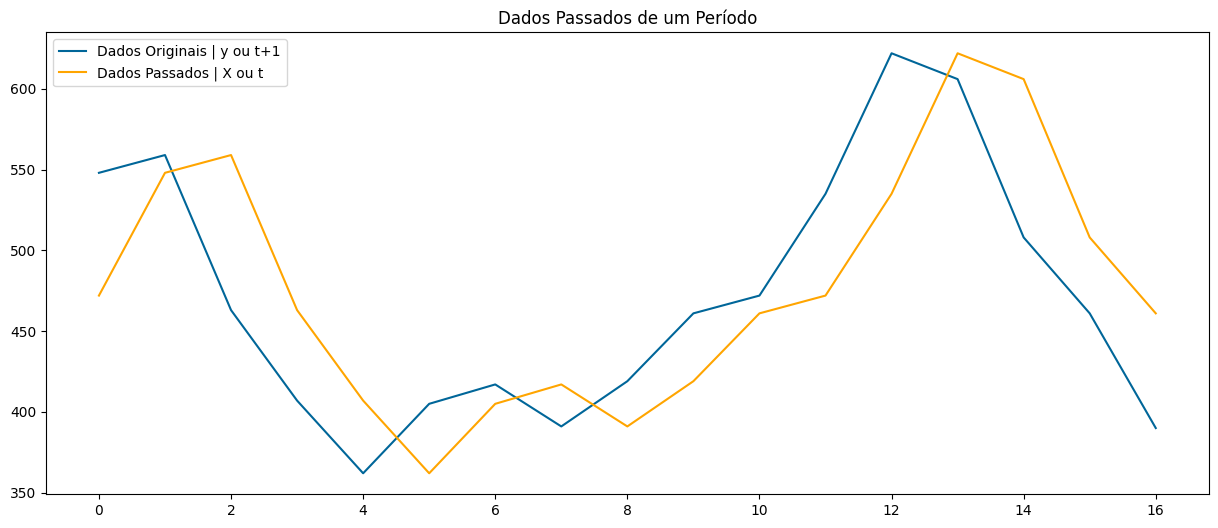

In [79]:
plt.plot(y_test, label='Dados Originais | y ou t+1', color='#006699')
plt.plot(X_test, label='Dados Passados | X ou t', color='orange')
plt.legend(loc='upper left')
plt.title('Dados Passados de um Período')
plt.show()

In [80]:
mdl = Sequential() #modelo do tipo sequence, empilhar camada
mdl.add(Dense(3, input_dim=lags, activation='relu')) #camada oculta com 3 neuronios, entrada 1 neuronio
mdl.add(Dense(1)) #camada de saida com 1 neuronio
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
62/62 - 1s - loss: 85287.7344 - 1s/epoch - 22ms/step
Epoch 2/200
62/62 - 0s - loss: 66260.9844 - 116ms/epoch - 2ms/step
Epoch 3/200
62/62 - 0s - loss: 51045.4297 - 122ms/epoch - 2ms/step
Epoch 4/200
62/62 - 0s - loss: 38663.4102 - 135ms/epoch - 2ms/step
Epoch 5/200
62/62 - 0s - loss: 28978.1465 - 84ms/epoch - 1ms/step
Epoch 6/200
62/62 - 0s - loss: 21096.4844 - 81ms/epoch - 1ms/step
Epoch 7/200
62/62 - 0s - loss: 15200.7021 - 96ms/epoch - 2ms/step
Epoch 8/200
62/62 - 0s - loss: 10813.0469 - 76ms/epoch - 1ms/step
Epoch 9/200
62/62 - 0s - loss: 7423.4390 - 84ms/epoch - 1ms/step
Epoch 10/200
62/62 - 0s - loss: 4993.1499 - 78ms/epoch - 1ms/step
Epoch 11/200
62/62 - 0s - loss: 3293.3081 - 82ms/epoch - 1ms/step
Epoch 12/200
62/62 - 0s - loss: 2228.5498 - 80ms/epoch - 1ms/step
Epoch 13/200
62/62 - 0s - loss: 1585.0503 - 86ms/epoch - 1ms/step
Epoch 14/200
62/62 - 0s - loss: 1214.1440 - 86ms/epoch - 1ms/step
Epoch 15/200
62/62 - 0s - loss: 1021.4907 - 82ms/epoch - 1ms/step
Epoch 16/

In [92]:
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Pontuação de Treino: 830.80 MSE (28.82 RMSE)
Pontuação de teste: 3184.43 MSE (56.43 RMSE)


In [93]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

1/1 [==============================] - 0s 22ms/step


In [99]:
test_predict_plot = np.empty_like(d)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(d)-1, :] = test_predict

In [100]:
train_predict_plot = np.empty_like(d)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

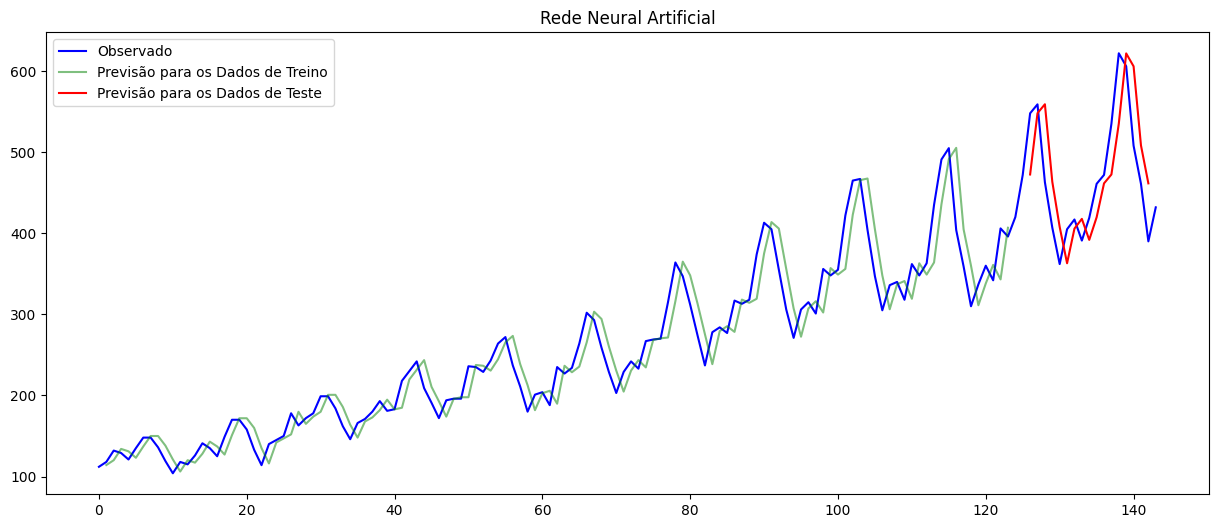

In [101]:
plt.plot(d, label='Observado', color='blue');
plt.plot(train_predict_plot, label='Previsão para os Dados de Treino', color='green', alpha=0.5);
plt.plot(test_predict_plot, label='Previsão para os Dados de Teste', color='red');
plt.legend(loc='best');
plt.title('Rede Neural Artificial')
plt.show()

#Transformers

In [102]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [105]:
normalizador = MinMaxScaler(feature_range=(-1, 1))
dados_normalizados = normalizador.fit_transform(data["#Passengers"].values.reshape(-1, 1))

In [106]:
class ConjuntoDadosSerieTemporal(Dataset):
    def __init__(self, serie, tamanho_sequencia):
        self.serie = serie
        self.tamanho_sequencia = tamanho_sequencia
    def __len__(self):
        return self.serie.shape[0] - self.tamanho_sequencia
    def __getitem__(self, indice):
        return (self.serie[indice:indice+self.tamanho_sequencia], self.serie[indice+self.tamanho_sequencia])

In [107]:
class CodificacaoPosicional(nn.Module):
    def __init__(self, d_modelo, max_len=5000):
        super(CodificacaoPosicional, self).__init__()

        pe = torch.zeros(max_len, d_modelo)
        posicao = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_modelo, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_modelo))
        pe[:, 0::2] = torch.sin(posicao * div_term)
        pe[:, 1::2] = torch.cos(posicao * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [108]:
class TransformerSerieTemporal(nn.Module):
    def __init__(self, d_modelo, nhead, num_camadas, dropout=0.3):
        super().__init__()
        self.codificacao_posicional = CodificacaoPosicional(d_modelo)
        self.transformer = nn.Transformer(d_model=d_modelo, nhead=nhead, num_encoder_layers=num_camadas,
                                          num_decoder_layers=num_camadas, dim_feedforward=64, dropout=dropout)
        self.fc = nn.Linear(d_modelo, 1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = self.codificacao_posicional(x)
        x = self.transformer(x, x)
        x = self.fc(x.permute(1, 0, 2))
        return x[:, -1, :]

In [109]:
tamanho_sequencia = 12
conjunto_dados = ConjuntoDadosSerieTemporal(torch.FloatTensor(dados_normalizados).squeeze(), tamanho_sequencia)
print(len(conjunto_dados))
print(conjunto_dados[2])

132
(tensor([-0.8919, -0.9035, -0.9344, -0.8803, -0.8301, -0.8301, -0.8764, -0.9421,
        -1.0000, -0.9459, -0.9575, -0.9151]), tensor(-0.8571))


In [110]:
carregador_dados = DataLoader(conjunto_dados, batch_size=16)

In [111]:
modelo = TransformerSerieTemporal(d_modelo=16, nhead=8, num_camadas=4, dropout=0.3)
criterio = nn.MSELoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.001)

In [116]:
for epoca in range(100):
    for sequencia, alvo in carregador_dados:
        sequencia = sequencia.unsqueeze(-1)
        alvo = alvo.unsqueeze(-1)

        saida = modelo(sequencia)
        perda = criterio(saida, alvo)

        otimizador.zero_grad()
        perda.backward()
        otimizador.step()
    print(f"Epoch {epoca}: Loss {perda.item()}")

Epoch 0: Loss 0.09134135395288467
Epoch 1: Loss 0.045391302555799484
Epoch 2: Loss 0.04311664029955864
Epoch 3: Loss 0.10650040954351425
Epoch 4: Loss 0.03864295408129692
Epoch 5: Loss 0.04995163157582283
Epoch 6: Loss 0.01984190195798874
Epoch 7: Loss 0.04966313764452934
Epoch 8: Loss 0.04991766810417175
Epoch 9: Loss 0.042184505611658096
Epoch 10: Loss 0.04364161565899849
Epoch 11: Loss 0.053856734186410904
Epoch 12: Loss 0.05633677914738655
Epoch 13: Loss 0.10956712067127228
Epoch 14: Loss 0.041368793696165085
Epoch 15: Loss 0.05269951745867729
Epoch 16: Loss 0.014014910906553268
Epoch 17: Loss 0.03364110365509987
Epoch 18: Loss 0.03476155549287796
Epoch 19: Loss 0.014824388548731804
Epoch 20: Loss 0.010604307055473328
Epoch 21: Loss 0.10680840909481049
Epoch 22: Loss 0.12419244647026062
Epoch 23: Loss 0.03580630570650101
Epoch 24: Loss 0.020566310733556747
Epoch 25: Loss 0.016239572316408157
Epoch 26: Loss 0.05563335493206978
Epoch 27: Loss 0.09074830263853073
Epoch 28: Loss 0.0168

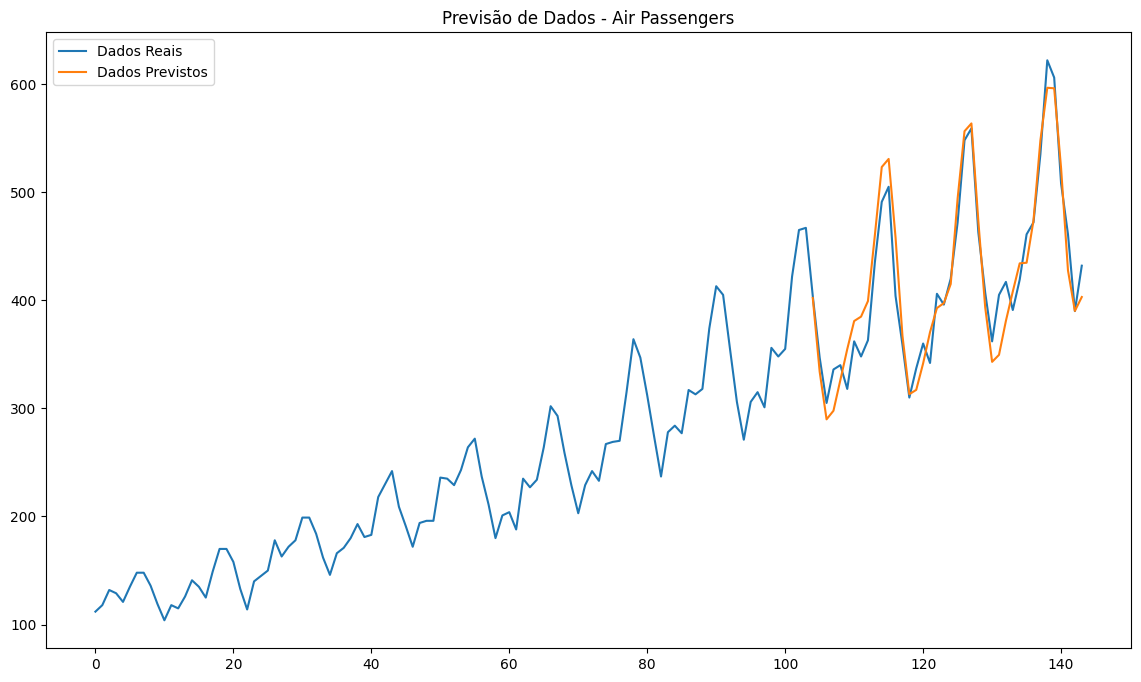

In [117]:
modelo.eval()

with torch.no_grad():
    previsoes = []

    for sequencia, _ in carregador_dados:
        sequencia = sequencia.unsqueeze(-1)
        saida = modelo(sequencia)
        previsoes.append(saida.squeeze(-1).numpy())

previsoes = np.concatenate(previsoes).reshape(-1, 1)
previsoes = normalizador.inverse_transform(previsoes)
dados_reais = normalizador.inverse_transform(dados_normalizados)

tamanho_treinamento = int(len(conjunto_dados) * 0.7)

plt.figure(figsize=(14, 8))
plt.plot(range(len(dados_reais)), dados_reais, label='Dados Reais')
plt.plot(range(tamanho_treinamento + tamanho_sequencia, len(dados_reais)), previsoes[tamanho_treinamento:], label='Dados Previstos')
plt.legend()
plt.title('Previsão de Dados - Air Passengers')
plt.show()